# Classical Multiclass Model Training on Code Smell Metrics
This notebook trains a classical machine learning model to classify code smells into four types based on CSQA-derived metrics: **Long Method**, **Large/God Class**, **Feature Envy**, and **Data Class**.
We use balanced and preprocessed data via SMOTE (Synthetic Minority Oversampling Technique) and evaluate the model's performance for comparison with transformer-based models in the main study.

## Load and Prepare the Balanced Multiclass Dataset
We use the `prepare_multiclass_dataset()` function to:
- read and clean CSQA merged metrics;
- map smell names to integer classes;
- balance the dataset using SMOTE;
- scale the features.

In [1]:
from src.data_processing.csqa_multiclass_prepare import prepare_multiclass_dataset

X_train, X_test, y_train, y_test, scaler = prepare_multiclass_dataset("../data/processed/csqa_merged_metrics.csv",
                                                                      "../data/processed/csqa_multiclass_balanced.csv",
                                                                      0.2,
                                                                      42)

✅ Saved balanced multiclass dataset: ../data/processed/csqa_multiclass_balanced.csv
Class distribution after SMOTE:
label
1    1985198
2    1985198
4    1985198
3    1985198
Name: count, dtype: int64



## Classical Multilabel Training with SmellyCode++ and CSQA Dataset

This section demonstrates how to:
- Prepare a unified dataset by merging SmellyCode++ and CSQA metric columns.
- Normalize numerical features using StandardScaler.
- Train and evaluate two classical multilabel classifiers: RandomForest and XGBoost.
- Save the resulting models and scalers using joblib for later inference.


### Load Datasets
We load:
- SmellyCode++ (raw metrics + labels)
- CSQA metrics to detect common overlapping metrics

In [1]:
import pandas as pd
df_smelly = pd.read_csv("../data/raw/52714583_multi-smell-dataset-v1_2.csv")
df_csqa = pd.read_csv("../data/processed/csqa_multiclass_balanced.csv")

### Determine Common Metrics
Find intersection of metric columns between datasets for fair merging.

In [2]:
column_mapping = {
    "Logical Lines": "LOC",
    "Cyclomatic Complexity": "CYCLO",
    "Distinct Operators": "NumberOfOperatorsWithoutAssignments",
    "Distinct Operands": "NumberOfUniqueIdentifiers",
    "Total Operands": "NumberOfIdentifies",
    "Total Operators": "NumberOfAssignments",
    "Length": "NumberOfTokens",
}

df_smelly_renamed = df_smelly.rename(columns=column_mapping)

common_metrics = list(set(df_smelly_renamed.columns) & set(df_csqa.columns))
print("Common metrics:", sorted(common_metrics))

Common metrics: ['CYCLO', 'LOC', 'NumberOfAssignments', 'NumberOfIdentifies', 'NumberOfOperatorsWithoutAssignments', 'NumberOfTokens', 'NumberOfUniqueIdentifiers']


## Preparing SmellyCode++ for Multilabel Format

The `SmellyCode++` dataset provides binary columns for each smell.
We will align the column names to match the label schema used in CSQA (`smell_mapping.py`) to ensure consistency.
We also compute a synthetic 'Clean' class for samples without any smell.

In [3]:
# Binary labels from SmellyCode++
smelly_label_cols = ["Long method", "God class", "Feature envy", "Data class"]

# Add multilabel columns in CSQA format
df_smelly_renamed["Long Method"] = df_smelly_renamed["Long method"]
df_smelly_renamed["God Class"] = df_smelly_renamed["God class"]
df_smelly_renamed["Large Class"] = df_smelly_renamed["God class"]  # alias
df_smelly_renamed["Feature Envy"] = df_smelly_renamed["Feature envy"]
df_smelly_renamed["Data Class"] = df_smelly_renamed["Data class"]
df_smelly_renamed["Clean"] = (df_smelly_renamed[smelly_label_cols].sum(axis=1) == 0).astype(int)

Convert CSQA Labels to Binary Format

In [4]:
# CSQA uses a single multiclass label column (1–4), so we convert it to multilabel binary format
df_csqa["Long Method"] = (df_csqa["label"] == 1).astype(int)
df_csqa["God Class"] = (df_csqa["label"] == 2).astype(int)
df_csqa["Large Class"] = (df_csqa["label"] == 2).astype(int)
df_csqa["Feature Envy"] = (df_csqa["label"] == 3).astype(int)
df_csqa["Data Class"] = (df_csqa["label"] == 4).astype(int)
df_csqa["Clean"] = 0  # All rows in CSQA represent some kind of smell

## Merge the Two Datasets

In [5]:
# Select matching columns: metrics + multilabels
columns_to_use = common_metrics + [
    "Long Method", "God Class", "Large Class", "Feature Envy", "Data Class", "Clean"
]

df_smelly_final = df_smelly_renamed[columns_to_use].copy()
df_csqa_final = df_csqa[columns_to_use].copy()

df_csqa_final["Source"] = "CSQA"
df_smelly_final["Source"] = "SmellyCode++"

# Merge datasets row-wise
df_merged = pd.concat([df_smelly_final, df_csqa_final], axis=0).reset_index(drop=True)
print(f"Merged dataset shape: {df_merged.shape}")

Merged dataset shape: (8048346, 14)


## Saving the Merged Dataset

We save the resulting dataset into the `data/processed/` folder for use in model training and evaluation.


In [6]:
df_merged.to_csv("../data/processed/merged_code_smells_dataset.csv", index=False)
print("Merged dataset saved to ../data/processed/merged_code_smells_dataset.csv")

Merged dataset saved to ../data/processed/merged_code_smells_dataset.csv


    • The merged dataset now includes 107k+ SmellyCode++ samples and 7.9M+ CSQA samples, all in binary multilabel format.
    • It is ready to be used in training classical ML models for multi-label code smell detection.
    • This step ensures structural consistency and semantic alignment between the two datasets, despite differences in origin and labeling approach.

# Training Classical Models for Multi-label Code Smell Classification

In this section, we will:
1. Load the merged dataset
2. Normalize numeric features
3. Train two classical models: RandomForestClassifier and XGBoostClassifier
4. Evaluate their multi-label performance using common metrics
5. Save trained models and scalers for later inference

In [7]:
import pandas as pd

# Load the prepared merged dataset
df = pd.read_csv("../data/processed/merged_code_smells_dataset.csv")

# Define features and target labels
feature_cols = [
    'NumberOfOperatorsWithoutAssignments', 'LOC', 'NumberOfUniqueIdentifiers',
    'NumberOfIdentifies', 'NumberOfAssignments', 'CYCLO', 'NumberOfTokens'
]
label_cols = ["Long Method", "God Class", "Feature Envy", "Data Class", "Clean"]

X = df[feature_cols]
y = df[label_cols]

## Normalize the Features

We apply StandardScaler normalization to ensure the classical models aren't biased by feature scales.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train-Test Split

We split the dataset into train and test sets with stratification based on multilabel binarization.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Train Random Forest and XGBoost (Multi-label)

We train two classifiers using scikit-learn’s `MultiOutputClassifier`, which allows us to treat each label as a separate binary classification task.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Train RandomForest
base_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

rf = MultiOutputClassifier(base_rf)
rf.fit(X_train, y_train)

# Train XGBoost
xgb = MultiOutputClassifier(
    XGBClassifier(eval_metric="logloss", random_state=42)
)
xgb.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


## Evaluate the Models

We will evaluate each model using:
- Accuracy per label
- F1-score (macro and micro)
- Hamming loss
- Subset accuracy (exact match)

This gives a well-rounded view of performance in a multi-label setting.

In [13]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    print(f"\n=== {model_name} Evaluation ===")
    for i, label in enumerate(y_test.columns):
        print(f"\n--- Label: {label} ---")
        print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

    print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
    print(f"Subset Accuracy (Exact Match): {accuracy_score(y_test, y_pred):.4f}")

# Evaluate RandomForest
evaluate_model(rf, X_test, y_test, "Random Forest")

# Evaluate XGBoost
evaluate_model(xgb, X_test, y_test, "XGBoost")


=== Random Forest Evaluation ===

--- Label: Long Method ---
              precision    recall  f1-score   support

           0       0.98      0.64      0.77   1212622
           1       0.46      0.96      0.63    397048

    accuracy                           0.72   1609670
   macro avg       0.72      0.80      0.70   1609670
weighted avg       0.85      0.72      0.74   1609670


--- Label: God Class ---
              precision    recall  f1-score   support

           0       0.90      0.85      0.87   1212975
           1       0.61      0.71      0.65    396695

    accuracy                           0.82   1609670
   macro avg       0.75      0.78      0.76   1609670
weighted avg       0.83      0.82      0.82   1609670


--- Label: Feature Envy ---
              precision    recall  f1-score   support

           0       0.97      0.60      0.74   1211686
           1       0.44      0.94      0.60    397984

    accuracy                           0.68   1609670
   macro av

## Save Trained Models and Scaler

We will use `joblib` to save the trained RandomForest and XGBoost models, as well as the fitted scaler, so they can be reused for inference later.

In [12]:
import joblib

# Save models and scaler
joblib.dump(rf, "../models/random_forest_multilabel.pkl")
joblib.dump(xgb, "../models/xgboost_multilabel.pkl")
joblib.dump(scaler, "../models/standard_scaler_multilabel.pkl")

['../models/standard_scaler_multilabel.pkl']

### Evaluation: Precision-Recall Curves and Confusion Matrices for Classical Models

In this section, we visualize the performance of the trained models (RandomForest and XGBoost) using:
- Precision-Recall (PR) curves for each smell label.
- Confusion matrices for each smell label.

This helps in comparing the classification performance per label, especially under class imbalance conditions.

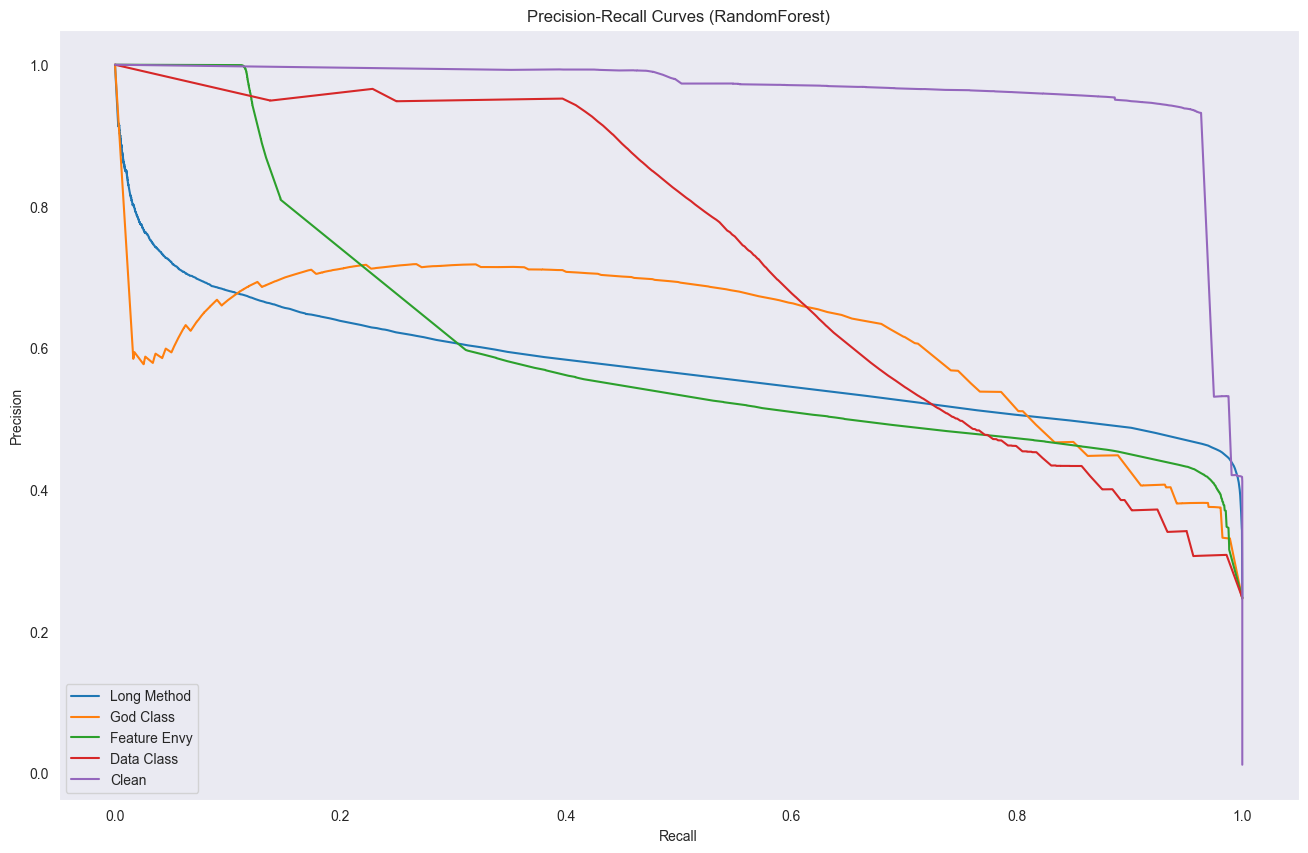

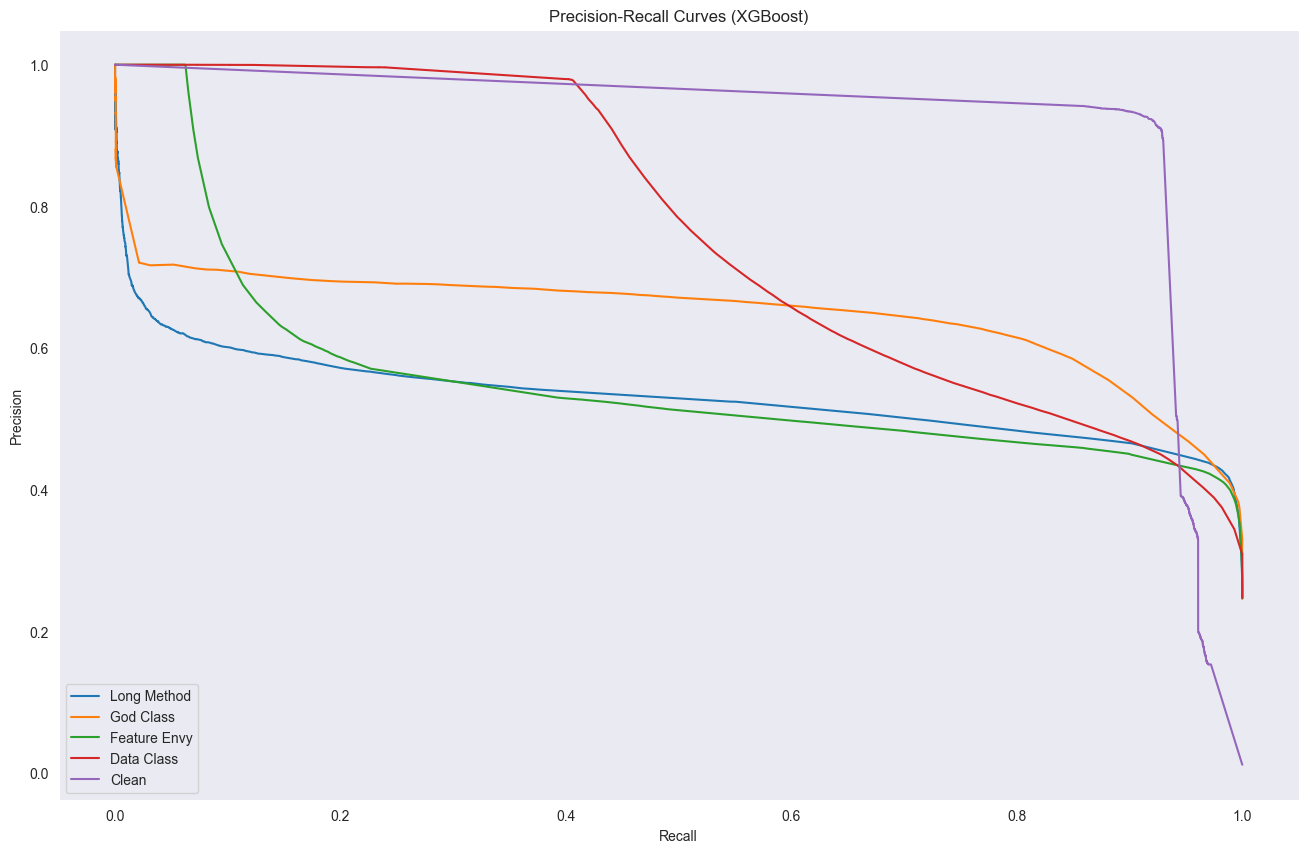

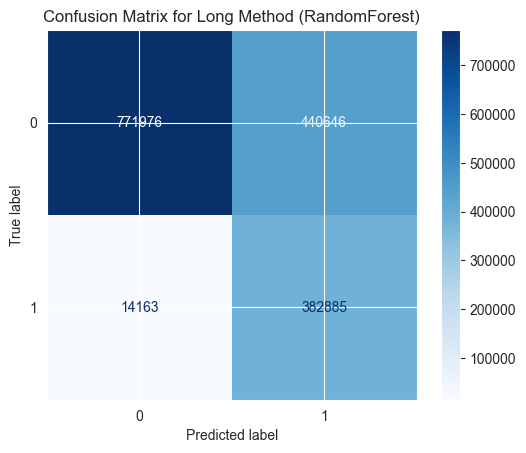

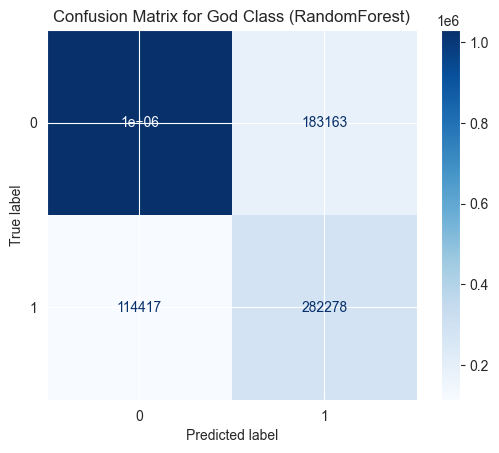

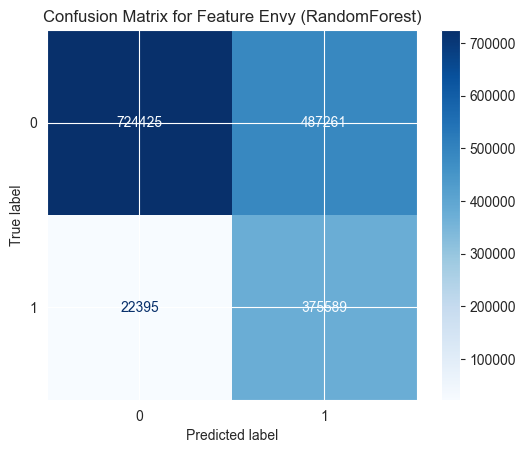

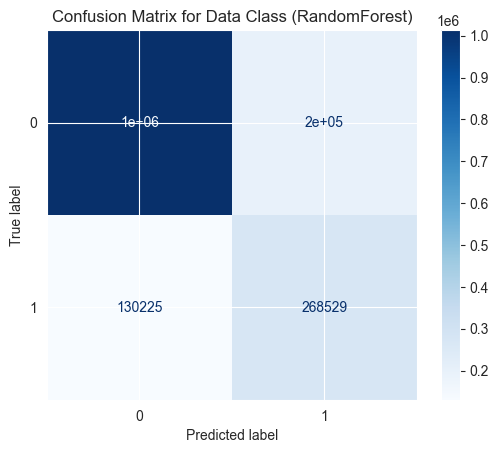

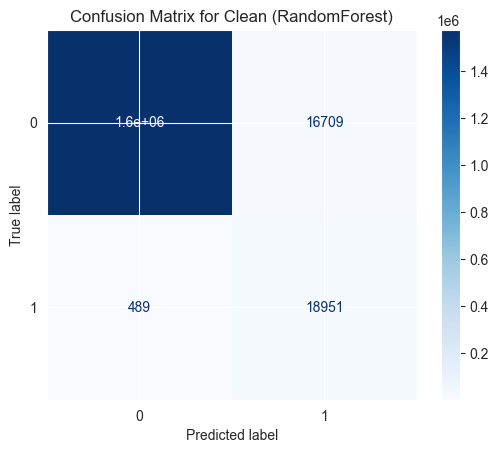

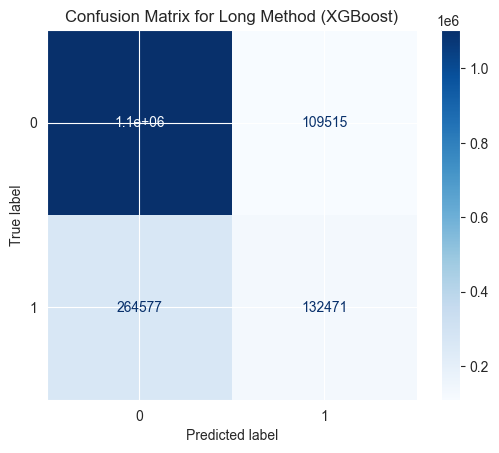

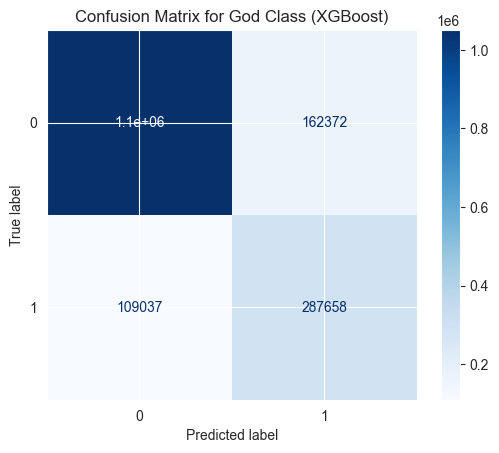

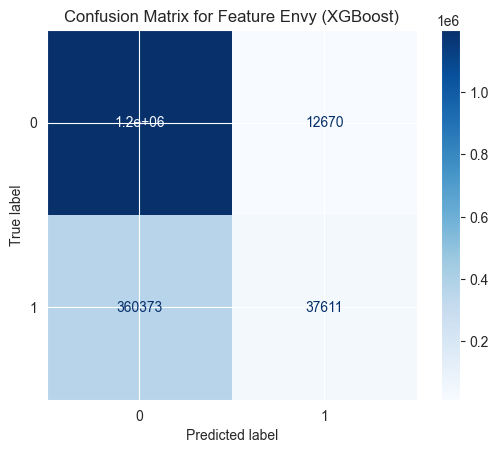

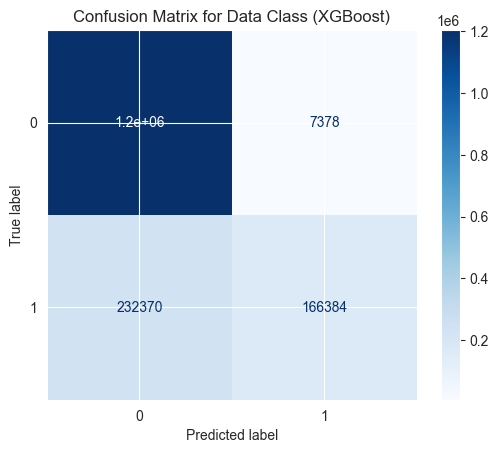

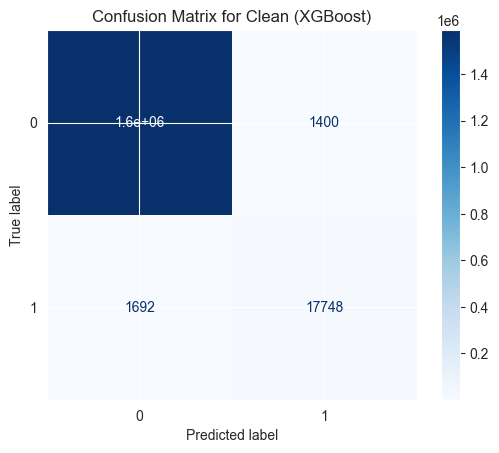

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns

# Predict probabilities and binary predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)

# y_proba_rf and y_proba_xgb are list of arrays, one per label
# Convert them to 2D array: shape (n_samples, n_classes)
y_proba_rf = np.array([proba[:, 1] for proba in y_proba_rf]).T
y_proba_xgb = np.array([proba[:, 1] for proba in y_proba_xgb]).T

# Extract label names
labels = y_test.columns.tolist()

def plot_pr_curves(y_true, y_proba, model_name):
    plt.figure(figsize=(16, 10))
    for i, label in enumerate(labels):
        precision, recall, _ = precision_recall_curve(y_true.iloc[:, i], y_proba[:, i])
        plt.plot(recall, precision, label=f'{label}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves ({model_name})')
    plt.legend()
    plt.grid()
    plt.show()

plot_pr_curves(y_test, y_proba_rf, "RandomForest")
plot_pr_curves(y_test, y_proba_xgb, "XGBoost")

def plot_confusion_matrices(y_true, y_pred, model_name):
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true.iloc[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {label} ({model_name})')
        plt.show()

plot_confusion_matrices(y_test, y_pred_rf, "RandomForest")
plot_confusion_matrices(y_test, y_pred_xgb, "XGBoost")

## Model Evaluation Summary

This section summarizes the evaluation of the two classical machine learning models — **Random Forest** and **XGBoost** — trained on the merged dataset combining *SmellyCode++* and *CSQA* samples.

### Evaluation Goal

The objective of this comparison is **not** to optimize classical models to perfection, but to establish a **baseline** for evaluating the effectiveness of transformer-based models in detecting code smells. According to the hypothesis of this research:

> *Self-supervised transformer models can effectively identify code smells in source code without manually labeled datasets. It is expected that such models will improve the detection accuracy of structural and semantic code defects compared to traditional heuristics and classical ML approaches.*

---

### Random Forest: Evaluation Metrics

| Code Smell     | Precision | Recall | F1-score | Support   |
|----------------|-----------|--------|----------|-----------|
| Long Method    | 0.46      | 0.96   | 0.63     | 397,048   |
| God Class      | 0.61      | 0.71   | 0.65     | 396,695   |
| Feature Envy   | 0.44      | 0.94   | 0.60     | 397,984   |
| Data Class     | 0.58      | 0.67   | 0.62     | 398,754   |
| Clean          | 0.53      | 0.97   | 0.69     | 19,440    |
| **Macro Avg**  | **0.72**  | **0.80**| **0.70** | -         |

- **Hamming Loss**: 0.1997
- **Subset Accuracy (Exact Match)**: 29.46%
- **Observation**: The model favors **high recall** over precision, especially for *Long Method* and *Feature Envy*, which leads to many false positives.

---

### XGBoost: Evaluation Metrics

| Code Smell     | Precision | Recall | F1-score | Support   |
|----------------|-----------|--------|----------|-----------|
| Long Method    | 0.55      | 0.33   | 0.41     | 397,048   |
| God Class      | 0.64      | 0.73   | 0.68     | 396,695   |
| Feature Envy   | 0.75      | 0.09   | 0.17     | 397,984   |
| Data Class     | 0.96      | 0.42   | 0.58     | 398,754   |
| Clean          | 0.93      | 0.91   | 0.92     | 19,440    |
| **Macro Avg**  | **0.77**  | **0.70**| **0.63** | -         |

- **Hamming Loss**: 0.1567
- **Subset Accuracy (Exact Match)**: 39.10%
- **Observation**: XGBoost shows **higher precision** than Random Forest, especially for *Clean* and *Data Class*, but struggles with *Feature Envy* due to low recall.

---

### Key Insights

- Both models perform well in identifying **Clean** samples due to their abundance in the dataset.
- Detection of **semantically complex smells** (e.g., *Feature Envy*, *Long Method*) is less accurate, likely due to the limitations of metric-based features.
- **Random Forest** tends to overpredict smelly classes (higher recall, lower precision), while **XGBoost** is more conservative (higher precision, lower recall).
- These weaknesses highlight the need for **semantic understanding of source code**, which classical models lack.

---

### Precision-Recall Curves

- PR curves support the above conclusions:
  - *Clean* and *God Class* show strong precision-recall tradeoffs.
  - *Long Method* and *Feature Envy* have weaker curves, indicating difficulties in separating positive and negative cases using metrics alone.

Figures:
- `pr-recall-rf.png`
- `pr-recall-xgb.png`

---

### 📌 Conclusion

The results confirm the limitations of classical models in detecting code smells — especially the semantic ones. These baselines validate the necessity of exploring **transformer-based models** that capture **contextual and structural relationships** within code.

In the next stage, we will evaluate transformer models (e.g., CodeBERT, GraphCodeBERT) on the same task for comparison.